# MNIST 이미지 데이터를 통한 CNN 이해

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
is_cuda = False
if torch.cuda.is_available():
    is_cuda = True

# 1. 이미지데이터 다운로드 및 이미지 전처리

- 데이터셋을 로컬에 가져온 후, DataLoader를 사용하여 데이터를 감싼다.
- torchvision 라이브러리의 변환 기능을 사용해 이미지 데이터를 텐서로 변환하고 정규화한다.

In [3]:
# 이미지 데이터 텐서 변환, 정규화
transformation = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))])
# MNIST 데이터 다운로드
train_dataset = datasets.MNIST('data/', train = True, transform=transformation, download=True)
test_dataset = datasets.MNIST('data/', train = False, transform=transformation, download=True)

# DataLoader로 다운받은 이미지 데이터를 감싼다.
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

## 1-1) 샘플데이터 시각화

In [4]:
sample_data = next(iter(train_loader))

In [5]:
def plot_img(image):
    image = image.numpy()[0]
    mean = 0.1307
    std = 0.3081
    image = ((mean * image) + std)
    plt.imshow(image, cmap='gray')

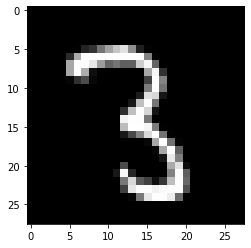

In [6]:
plot_img(sample_data[0][2])

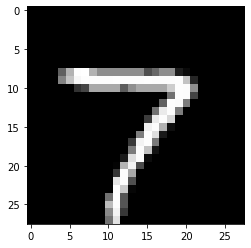

In [7]:
plot_img(sample_data[0][1])

# 2. CNN 모델 구축

- 생성할 네트워크 아키텍처는 다음으로 구성한다.
- Conv2d
- MaxPool2d
- ReLU
- 뷰
- 선형레이어

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320) # 2차원의 텐서를 1차원 벡터로 변형 / view()에서 -1은 다음 파라미터의 크기로 계산하겠다는 의미이다.
        x = F.relu(self.fc1(x))
        #x = F.dropout(x,p=0.1, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

In [9]:
model = Net()
if is_cuda:
    model.cuda()

In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [11]:
data, target = next(iter(train_loader))

In [12]:
if is_cuda:
    data = data.cuda()

In [13]:
output = model(Variable(data))

In [14]:
output.size()

torch.Size([32, 10])

In [15]:
target.size()

torch.Size([32])

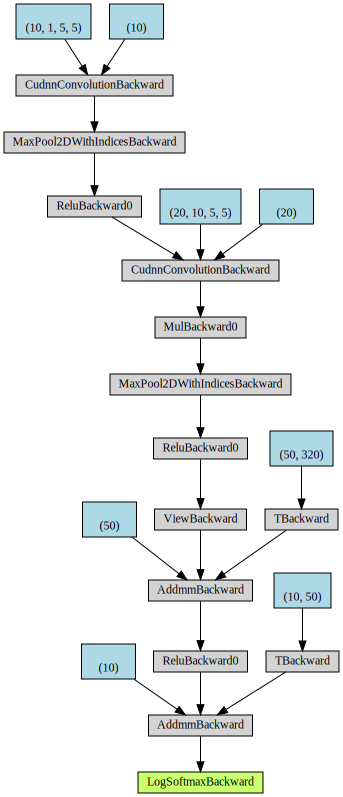

In [16]:
# 모델 시각화
import re
from torchviz import make_dot

make_dot(model(Variable(data)))

In [17]:
# fit 함수는 특정 에폭에 대한 모델의 오차와 정확도를 반환한다.

def fit(epoch, model, data_loader, phase='training', volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    
    running_loss = 0.0
    running_correct = 0
    
    for batch_idx, (data, target) in enumerate(data_loader):
        if is_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile), Variable(target)
        
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        
        running_loss += F.nll_loss(output, target, size_average=False).data
        preds = output.data.max(dim=1, keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss.item() / len(data_loader.dataset)
    accuracy = 100.0 * running_correct.item() / len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)} {accuracy:{10}.{4}}')
    
    return loss,accuracy

#### __fit 메서드는 학습과 검증 단계를 구분해 다른 로직을 수행한다. 다른 로직으로 수행하는 이유는 다음과 같다.__
#### - 학습 모드에서는 드롭아웃을 적용해 일정 비율의 값을 제거한다. 드롭아웃은 검증 또는 테스트 단계에서 적용되면 안된다.
#### - 학습 모드의 경우, 기울기를 계산하고 모델의 파라미터 값을 변경한다. 그러나 검증 및 테스트 단계에서는 이러한 역전파를 수행하고 파라미터를 변경하는 작업이 필요 없다.

# 3. 모델 학습

In [18]:
# train과 test의 loss, accuracy를 리스트형식으로 저장
train_losses, train_accuracy = [], []
val_losses, val_accuracy = [],[]

# 모델 학습을 20회 반복
for epoch in range(1,20):
    epoch_loss, epoch_accuracy = fit(epoch, model, train_loader, phase = 'training')
    val_epoch_loss, val_epoch_accuracy = fit(epoch, model, test_loader, phase = 'validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

/home/pirl/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is  0.75 and training accuracy is 45644/60000      76.07
validation loss is  0.16 and validation accuracy is 9518/10000      95.18
training loss is  0.21 and training accuracy is 56320/60000      93.87
validation loss is 0.099 and validation accuracy is 9696/10000      96.96
training loss is  0.15 and training accuracy is 57272/60000      95.45
validation loss is 0.071 and validation accuracy is 9777/10000      97.77
training loss is  0.13 and training accuracy is 57813/60000      96.36
validation loss is 0.059 and validation accuracy is 9804/10000      98.04
training loss is  0.11 and training accuracy is 58073/60000      96.79
validation loss is 0.056 and validation accuracy is 9819/10000      98.19
training loss is   0.1 and training accuracy is 58265/60000      97.11
validation loss is  0.05 and validation accuracy is 9848/10000      98.48
training loss is  0.09 and training accuracy is 58387/60000      97.31
validation loss is 0.045 and validation accuracy is 9858/10

## 3-1) Train, Test Loss 시각화

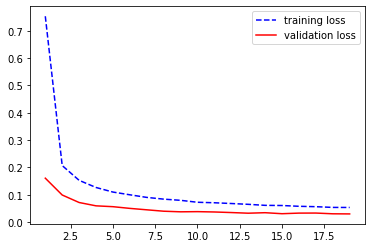

In [19]:
plt.plot(range(1, len(train_losses)+1), train_losses, 'b--', label = 'training loss')
plt.plot(range(1, len(val_losses)+1), val_losses, 'r', label = 'validation loss')
plt.legend()

## 3-2) Train, Test Accuracy 시각화

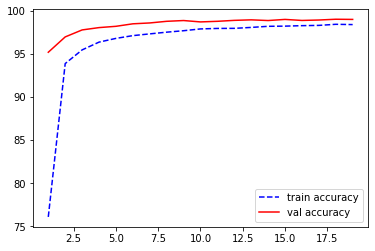

In [20]:
plt.plot(range(1, len(train_accuracy)+1), train_accuracy, 'b--', label = 'train accuracy')
plt.plot(range(1, len(val_accuracy)+1), val_accuracy, 'r', label = 'val accuracy')
plt.legend()

#### - 20회 에폭을 마친 아키텍처는 Test Accuracy가 __98.99%__ 까지 달성했다.
#### - 간단한 컨볼루션 레이어를 통해 좋은 결과를 얻을 수 있었다.